In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Evaluating the Importance of Formula 1 Race Constraints in Predicting Driver Performance**

**Objective:**
Formula 1 is a highly dynamic and competitive motorsport where numerous variables can impact a driver's performance. The objective of the project is to assess the significance of Formula 1 race constraints in predicting driver performance. By analyzing various race-related variables and constraints, such as driver confidence, track characteristics, and qualifying race position, and pitstop times, to evaluate which features are most important when it comes to predicting driver standings in a given race.

**Approach:**
Utilizing a machine learning framework, our approach to predicting F1 driver standings encompasses a multifaceted strategy. We aim to compile historical race data while integrating features extracted from a convolutional neural network analyzing race track images, embracing a multimodal methodology. Through an ablation study, we seek to discern the most influential features crucial in predicting these variables. Comparing our outcomes with RF/SHAP feature importance generators will allow us to pinpoint any disparities and refine our model. The implications of our findings extend beyond prediction accuracy; they could revolutionize race strategy, inform car design, and elevate driver training, culminating in heightened performance and enhanced competitiveness within the sport.

## Data Cleaning, Preprocessing, and Exploratory Analysis

Loading the historical race data, merging differne datasets like results, races, qualifying, etc. into one, renaming common columns to make more sense, accounting for team name changes, calculating driver ages, cleaning up the data, adding additional features like driver confidence and constructor reliability, and filtering active drivers and constructors.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
results = pd.read_csv(r'/content/drive/MyDrive/F1/f1-dataset/results.csv')
races = pd.read_csv(r'/content/drive/MyDrive/F1/f1-dataset/races.csv')
quali = pd.read_csv(r'/content/drive/MyDrive/F1/f1-dataset/qualifying.csv')
drivers = pd.read_csv(r'/content/drive/MyDrive/F1/f1-dataset/drivers.csv')
constructors = pd.read_csv(r'/content/drive/MyDrive/F1/f1-dataset/constructors.csv')
circuit = pd.read_csv(r'/content/drive/MyDrive/F1/f1-dataset/circuits.csv')
pitstops = pd.read_csv(r'/content/drive/MyDrive/F1/f1-dataset/pit_stops.csv')
laptimes = pd.read_csv(r'/content/drive/MyDrive/F1/f1-dataset/lap_times.csv')

In [ ]:
data = pd.merge(races,results,how='inner',on=['raceId'])
data = pd.merge(data,quali,how='inner',on=['raceId','driverId','constructorId'])
data = pd.merge(data,drivers,how='inner',on=['driverId'])
data = pd.merge(data,constructors,how='inner',on=['constructorId'])
data = pd.merge(data,circuit,how='inner',on=['circuitId'])

<ipython-input-4-e53c02d30ee2>:5: FutureWarning: Passing 'suffixes' which cause duplicate columns {'url_x'} in the result is deprecated and will raise a MergeError in a future version.
  data = pd.merge(data,circuit,how='inner',on=['circuitId'])


In [ ]:
data.columns

Index(['raceId', 'year', 'round', 'circuitId', 'name_x', 'date', 'time_x',
       'url_x', 'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date',
       'fp3_time', 'quali_date', 'quali_time', 'sprint_date', 'sprint_time',
       'resultId', 'driverId', 'constructorId', 'number_x', 'grid',
       'position_x', 'positionText', 'positionOrder', 'points', 'laps',
       'time_y', 'milliseconds', 'fastestLap', 'rank', 'fastestLapTime',
       'fastestLapSpeed', 'statusId', 'qualifyId', 'number_y', 'position_y',
       'q1', 'q2', 'q3', 'driverRef', 'number', 'code', 'forename', 'surname',
       'dob', 'nationality_x', 'url_y', 'constructorRef', 'name_y',
       'nationality_y', 'url_x', 'circuitRef', 'name', 'location', 'country',
       'lat', 'lng', 'alt', 'url_y'],
      dtype='object')

In [ ]:
#dropping unnecessary columns
cols_to_drop = ['round','circuitId','time_x','url_x','resultId',
                 'constructorId','number_x','positionText','position_x',
                 'positionOrder','laps','time_y','rank', 'fastestLapTime',
                'fastestLapSpeed','qualifyId','driverRef','number','code',
                'url_y','circuitRef','location','lat','lng','alt',
                'number_y','points','constructorRef','name_x',
                'fastestLap','q2','q3','milliseconds','q1', 'fp1_date', 'fp1_time',
                'fp2_date', 'fp2_time', 'fp3_date', 'fp3_time', 'quali_date',
                'quali_time', 'sprint_date', 'sprint_time']

data = data.drop(cols_to_drop, 1)

<ipython-input-6-eae33c6daf9f>:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data = data.drop(cols_to_drop, 1)


In [ ]:
data.columns

Index(['raceId', 'year', 'date', 'driverId', 'grid', 'statusId', 'position_y',
       'forename', 'surname', 'dob', 'nationality_x', 'name_y',
       'nationality_y', 'name', 'country'],
      dtype='object')

In [ ]:
#considering data points from 1980
data = data[data['year']>=1980]

In [ ]:
#rename the columns
data.rename(columns={'name':'GP_name','position_y':'position','grid':'quali_pos','name_y':'constructor','nationality_x':'driver_nationality','nationality_y':'constructor_nationality'},inplace=True)
data['driver'] = data['forename']+' '+data['surname']
data['date'] = pd.to_datetime(data['date'])
data['dob'] = pd.to_datetime(data['dob'])

In [ ]:
#creating a driver age parameter
data['age_at_gp_in_days'] = abs(data['dob']-data['date'])
data['age_at_gp_in_days'] = data['age_at_gp_in_days'].apply(lambda x: str(x).split(' ')[0])

In [ ]:
#Some of the constructors changed their name over the year so replacing old names with current name
data['constructor'] = data['constructor'].apply(lambda x: 'Aston Martin' if x=='Force India' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Aston Martin' if x=='Racing Point' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Alfa Romeo' if x=='Sauber' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Alpine F1 Team' if x=='Lotus F1' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Alpine F1 Team' if x=='Renault' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'AlphaTauri' if x=='Toro Rosso' else x)

In [ ]:
data['driver_nationality'] = data['driver_nationality'].apply(lambda x: str(x)[:3])
data['constructor_nationality'] = data['constructor_nationality'].apply(lambda x: str(x)[:3])
data['country'] = data['country'].apply(lambda x: 'Bri' if x=='UK' else x)
data['country'] = data['country'].apply(lambda x: 'Ame' if x=='USA' else x)
data['country'] = data['country'].apply(lambda x: 'Fre' if x=='Fra' else x)
data['country'] = data['country'].apply(lambda x: str(x)[:3])
data['driver_home'] = data['driver_nationality'] == data['country']
data['constructor_home'] = data['constructor_nationality'] == data['country']
data['driver_home'] = data['driver_home'].apply(lambda x: int(x))
data['constructor_home'] = data['constructor_home'].apply(lambda x: int(x))

In [ ]:
#reasons for DNF(did not finish)
data['driver_dnf'] = data['statusId'].apply(lambda x: 1 if x in [3,4,20,29,31,41,68,73,81,97,82,104,107,130,137] else 0)
data['constructor_dnf'] = data['statusId'].apply(lambda x: 1 if x not in [3,4,20,29,31,41,68,73,81,97,82,104,107,130,137,1] else 0)
data.drop(['forename','surname'],1,inplace=True)

<ipython-input-13-25c0911fc15d>:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data.drop(['forename','surname'],1,inplace=True)


In [ ]:
#calculating driver confidence
dnf_by_driver = data.groupby('driver').sum()['driver_dnf']
driver_race_entered = data.groupby('driver').count()['driver_dnf']
driver_dnf_ratio = (dnf_by_driver/driver_race_entered)
driver_confidence = 1-driver_dnf_ratio
driver_confidence_dict = dict(zip(driver_confidence.index,driver_confidence))

<ipython-input-14-d3e5a73f128e>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dnf_by_driver = data.groupby('driver').sum()['driver_dnf']


In [ ]:
#calculating constructor reliability
dnf_by_constructor = data.groupby('constructor').sum()['constructor_dnf']
constructor_race_entered = data.groupby('constructor').count()['constructor_dnf']
constructor_dnf_ratio = (dnf_by_constructor/constructor_race_entered)
constructor_reliablity = 1-constructor_dnf_ratio
constructor_reliablity_dict = dict(zip(constructor_reliablity.index,constructor_reliablity))

<ipython-input-15-d472a45a6609>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dnf_by_constructor = data.groupby('constructor').sum()['constructor_dnf']


In [ ]:
data['driver_confidence'] = data['driver'].apply(lambda x:driver_confidence_dict[x])
data['constructor_reliablity'] = data['constructor'].apply(lambda x:constructor_reliablity_dict[x])
#removing retired drivers and constructors
active_constructors = ['Alpine F1 Team', 'Williams', 'McLaren', 'Ferrari', 'Mercedes',
                       'AlphaTauri', 'Aston Martin', 'Alfa Romeo', 'Red Bull',
                       'Haas F1 Team']
active_drivers = ['Daniel Ricciardo', 'Kevin Magnussen', 'Carlos Sainz',
                  'Valtteri Bottas', 'Lance Stroll', 'George Russell',
                  'Lando Norris', 'Fernando Alonso', 'Guanyu Zhou',
                  'Charles Leclerc', 'Lewis Hamilton', 'Oscar Piastri',
                  'Max Verstappen', 'Pierre Gasly', 'Alexander Albon',
                  'Sergio Pérez', 'Esteban Ocon', 'Yuki Tsunoda',
                  'Nico Hülkenberg', 'Logan Sargeant']
data['active_driver'] = data['driver'].apply(lambda x: int(x in active_drivers))
data['active_constructor'] = data['constructor'].apply(lambda x: int(x in active_constructors))


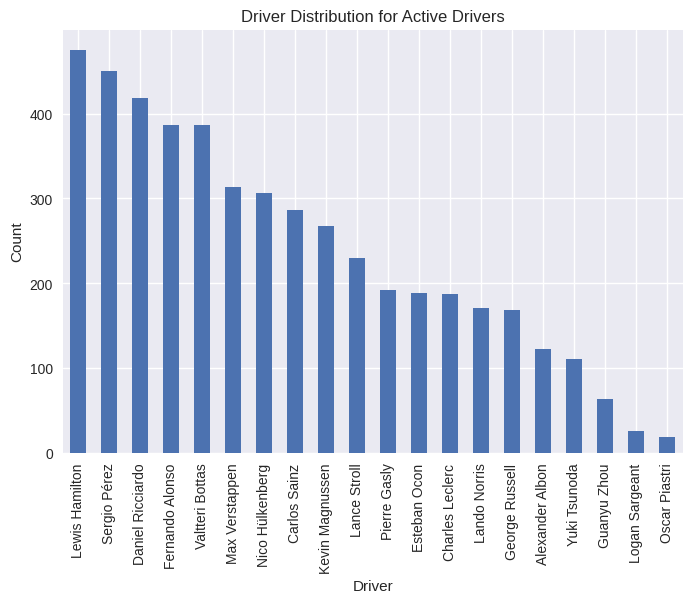

In [ ]:
data[data['active_driver']==1][['driver']]
driver_distribution = data[data['active_driver'] == 1]['driver'].value_counts()

import matplotlib.pyplot as plt

driver_distribution.plot(kind='bar')
plt.title('Driver Distribution for Active Drivers')
plt.xlabel('Driver')
plt.ylabel('Count')
plt.show()

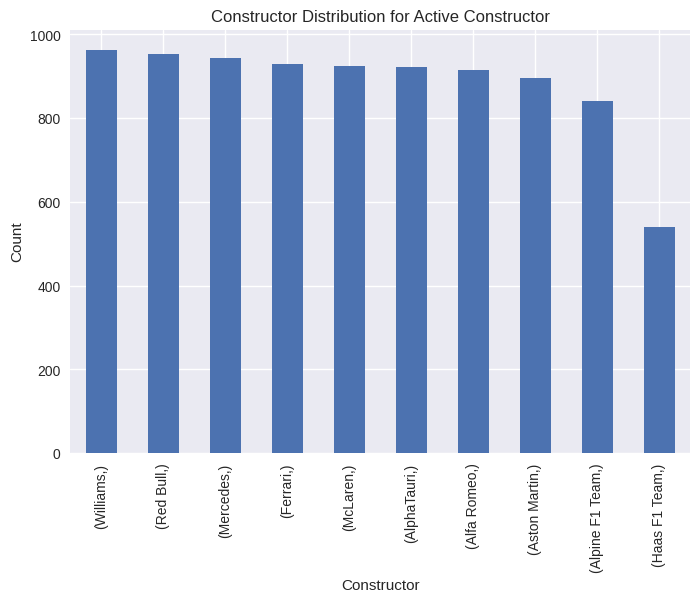

In [ ]:

constructor_distribution = data[data['active_constructor']==1][['constructor']].value_counts()

import matplotlib.pyplot as plt

constructor_distribution.plot(kind='bar')
plt.title('Constructor Distribution for Active Constructor')
plt.xlabel('Constructor')
plt.ylabel('Count')
plt.show()



## Iteration 1: Baseline


---




### 1.1 Using both active constructors and active drivers and their relevant features

In [ ]:
x_cd = data[['GP_name','quali_pos','constructor','driver','position','driver_confidence','constructor_reliablity','active_driver','active_constructor','age_at_gp_in_days']]
x_cd = x_cd[(x_cd['active_driver']==1)&(x_cd['active_constructor']==1)]

In [ ]:
constructor_names = ['Ferrari', 'Red Bull', 'Mercedes', 'Aston Martin', 'Williams', 'Alfa Romeo', 'AlphaTauri', 'McLaren', 'Alpine F1 Team', 'Haas F1 Team']

for name in constructor_names:
    reliability = x_cd.loc[x_cd['constructor'] == name, 'constructor_reliablity'].values[0]
    print(f"{name}: {reliability}")

Ferrari: 0.8271739130434783
Red Bull: 0.7827298050139275
Mercedes: 0.8927911275415896
Aston Martin: 0.613747954173486
Williams: 0.5560391730141458
Alfa Romeo: 0.40258064516129033
AlphaTauri: 0.4830633284241531
McLaren: 0.6477644492911668
Alpine F1 Team: 0.6104060913705585
Haas F1 Team: 0.37299035369774924


In [ ]:
drivers = ['Daniel Ricciardo', 'Kevin Magnussen', 'Carlos Sainz',
                  'Valtteri Bottas', 'Lance Stroll', 'George Russell',
                  'Lando Norris', 'Fernando Alonso', 'Guanyu Zhou',
                  'Charles Leclerc', 'Lewis Hamilton', 'Oscar Piastri',
                  'Max Verstappen', 'Pierre Gasly', 'Alexander Albon',
                  'Sergio Pérez', 'Esteban Ocon', 'Yuki Tsunoda',
                  'Nico Hülkenberg', 'Logan Sargeant']

driver_confidence_dict = {}

for driver in drivers:
    driver_data = x_cd[x_cd['driver'] == driver]
    if len(driver_data) > 0:
        driver_confidence_dict[driver] = driver_data.iloc[0]['driver_confidence']
    else:
        driver_confidence_dict[driver] = 0.8

for driver, confidence in driver_confidence_dict.items():
    print(f"{driver}: {confidence}")

Daniel Ricciardo: 0.9527896995708155
Kevin Magnussen: 0.9215686274509804
Carlos Sainz: 0.9022988505747126
Valtteri Bottas: 0.9530516431924883
Lance Stroll: 0.8955223880597015
George Russell: 0.9361702127659575
Lando Norris: 0.9574468085106383
Fernando Alonso: 0.9405099150141643
Guanyu Zhou: 0.9411764705882353
Charles Leclerc: 0.8956521739130435
Lewis Hamilton: 0.9440993788819876
Oscar Piastri: 0.9166666666666666
Max Verstappen: 0.9142857142857143
Pierre Gasly: 0.9159663865546218
Alexander Albon: 0.9285714285714286
Sergio Pérez: 0.939516129032258
Esteban Ocon: 0.9426229508196722
Yuki Tsunoda: 0.9285714285714286
Nico Hülkenberg: 0.9076923076923077
Logan Sargeant: 0.8333333333333334


In [ ]:
x_cd.head()

,GP_name,quali_pos,constructor,driver,position,driver_confidence,constructor_reliablity,active_driver,active_constructor,age_at_gp_in_days
20,Albert Park Grand Prix Circuit,10,Alpine F1 Team,Fernando Alonso,12,0.94051,0.610406,1,1,10105
21,Albert Park Grand Prix Circuit,11,Alpine F1 Team,Fernando Alonso,12,0.94051,0.610406,1,1,9727
22,Albert Park Grand Prix Circuit,3,Alpine F1 Team,Fernando Alonso,3,0.94051,0.610406,1,1,9013
23,Albert Park Grand Prix Circuit,13,Alpine F1 Team,Fernando Alonso,13,0.94051,0.610406,1,1,8621
24,Albert Park Grand Prix Circuit,5,Alpine F1 Team,Fernando Alonso,5,0.94051,0.610406,1,1,8257


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder
from sklearn.model_selection import cross_val_score,StratifiedKFold,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix,precision_score,f1_score,recall_score
from sklearn.model_selection import train_test_split

plt.style.use('seaborn')

<ipython-input-21-d8331eb9c742>:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [ ]:
sc  = StandardScaler()
le = LabelEncoder()

x = x_cd.copy()
x['GP_name'] = le.fit_transform(x['GP_name'])
x['constructor'] = le.fit_transform(x['constructor'])
x['driver'] = le.fit_transform(x['driver'])
x['GP_name'] = le.fit_transform(x['GP_name'])
train, test = train_test_split(x, test_size=0.2)
X_train = train.drop(['position','active_driver','active_constructor'],1)
X_test = test.drop(['position','active_driver','active_constructor'],1)
y_train = train['position']
y_test = test['position']

<ipython-input-22-3a957d88eafb>:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_train = train.drop(['position','active_driver','active_constructor'],1)
<ipython-input-22-3a957d88eafb>:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_test = test.drop(['position','active_driver','active_constructor'],1)


In [ ]:
# Encode 'GP_name' column
encoded_GP_names = le.fit_transform(x_cd['GP_name'])

# Create a dictionary mapping original 'GP_name' values to their encoded values
mapping_dict = dict(zip(x_cd['GP_name'], encoded_GP_names))

In [ ]:
mapping_dict

{'Albert Park Grand Prix Circuit': 0,
 'Sepang International Circuit': 30,
 'Shanghai International Circuit': 31,
 'Bahrain International Circuit': 7,
 'Circuit de Barcelona-Catalunya': 13,
 'Circuit de Monaco': 14,
 'Istanbul Park': 22,
 'Silverstone Circuit': 32,
 'Nürburgring': 28,
 'Hungaroring': 20,
 'Valencia Street Circuit': 35,
 'Circuit de Spa-Francorchamps': 16,
 'Autodromo Nazionale di Monza': 3,
 'Marina Bay Street Circuit': 26,
 'Suzuka Circuit': 34,
 'Autódromo José Carlos Pace': 6,
 'Yas Marina Circuit': 36,
 'Circuit Gilles Villeneuve': 10,
 'Circuit de Nevers Magny-Cours': 15,
 'Hockenheimring': 19,
 'Fuji Speedway': 18,
 'Indianapolis Motor Speedway': 21,
 'Autodromo Enzo e Dino Ferrari': 1,
 'Red Bull Ring': 29,
 'Korean International Circuit': 24,
 'Sochi Autodrom': 33,
 'Baku City Circuit': 8,
 'Circuit of the Americas': 17,
 'Autódromo Hermanos Rodríguez': 4,
 'Circuit Paul Ricard': 12,
 'Buddh International Circuit': 9,
 'Autodromo Internazionale del Mugello': 2,

In [ ]:
X_train.head()

,GP_name,quali_pos,constructor,driver,driver_confidence,constructor_reliablity,age_at_gp_in_days
8370,29,0,0,18,0.953052,0.402581,12004
1710,13,20,9,12,0.833333,0.556039,8190
6744,10,10,2,14,0.907692,0.610406,10889
9091,4,3,7,11,0.944099,0.892791,12347
7009,10,13,3,17,0.939516,0.613748,8899


In [ ]:
#cross validation for diffrent models
models = [LogisticRegression(),DecisionTreeClassifier(),RandomForestClassifier(),SVC(),GaussianNB(),KNeighborsClassifier()]
names = ['LogisticRegression','DecisionTreeClassifier','RandomForestClassifier','SVC','GaussianNB','KNeighborsClassifier']
model_dict = dict(zip(models,names))
mean_results = []
results = []
name = []
for model in models:
    cv = StratifiedKFold(n_splits=10,random_state=1, shuffle = True)
    result = cross_val_score(model,X_train,y_train,cv=cv,scoring='accuracy')
    mean_results.append(result.mean())
    results.append(result)
    name.append(model_dict[model])
    print(f'{model_dict[model]} : {result.mean()}')

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/mod

LogisticRegression : 0.17154247447091903
DecisionTreeClassifier : 0.573068669527897


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


RandomForestClassifier : 0.5739177889595974


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


SVC : 0.07394923782743822
GaussianNB : 0.33277896995708156


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


KNeighborsClassifier : 0.08080324108332101


In [ ]:
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_pred = rf.predict(X_test)
print('Training Accuracy: ', accuracy_score(y_train, y_train_pred))
print('Testing Accuracy: ', accuracy_score(y_test, y_pred))

Training Accuracy:  1.0
Testing Accuracy:  0.570446735395189


Text(0.5, 0, 'Random Forest Feature Importance')

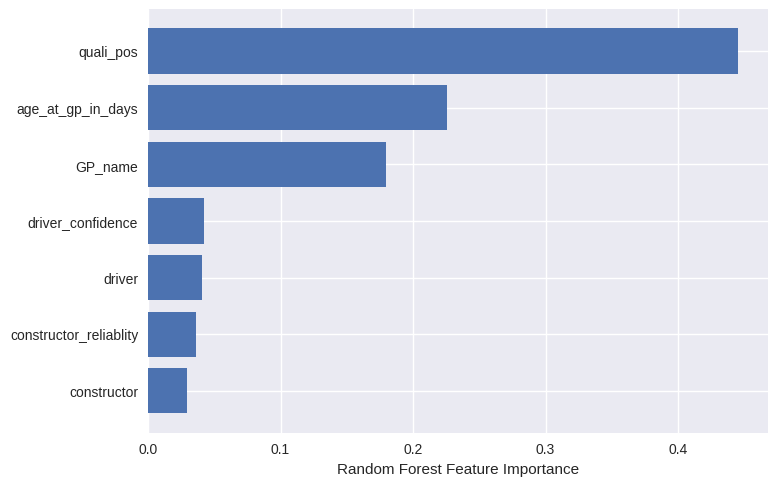

In [ ]:
sorted_idx = rf.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### 1.2 Using only active drivers and their relevant features




In [ ]:
x_d = data[['GP_name','quali_pos','driver','age_at_gp_in_days','position','driver_confidence','active_driver']]

In [ ]:
x_d = x_d[x_d['active_driver']==1]

In [ ]:
x_d.head()

,GP_name,quali_pos,driver,age_at_gp_in_days,position,driver_confidence,active_driver
20,Albert Park Grand Prix Circuit,10,Fernando Alonso,10105,12,0.94051,1
21,Albert Park Grand Prix Circuit,11,Fernando Alonso,9727,12,0.94051,1
22,Albert Park Grand Prix Circuit,3,Fernando Alonso,9013,3,0.94051,1
23,Albert Park Grand Prix Circuit,13,Fernando Alonso,8621,13,0.94051,1
24,Albert Park Grand Prix Circuit,5,Fernando Alonso,8257,5,0.94051,1


In [ ]:
sc  = StandardScaler()
le = LabelEncoder()
x_d['driver_encoded'] = le.fit_transform(x_d['driver'])
# After label encoding
driver_nums = x_d['driver_encoded'].unique()
driver_names = x_d['driver'].unique()

# Create a dictionary that maps driver numbers to names
driver_dict = dict(zip(driver_nums, driver_names))
x_d['GP_name'] = le.fit_transform(x_d['GP_name'])
x_d['GP_name'] = le.fit_transform(x_d['GP_name'])
x_d['age_at_gp_in_days'] = sc.fit_transform(x_d[['age_at_gp_in_days']])

train, test = train_test_split(x_d, test_size=0.2)

X_d_train = train.drop(['position','active_driver','driver'],1)
X_d_test = test.drop(['position','active_driver','driver'],1)
y_d_train = train['position']
y_d_test = test['position']

<ipython-input-32-508b4f0134ae>:16: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_d_train = train.drop(['position','active_driver','driver'],1)
<ipython-input-32-508b4f0134ae>:17: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_d_test = test.drop(['position','active_driver','driver'],1)


In [ ]:
X_d_train.columns

Index(['GP_name', 'quali_pos', 'age_at_gp_in_days', 'driver_confidence',
       'driver_encoded'],
      dtype='object')

In [ ]:
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_d_train, y_d_train)
y_d_train_pred = rf.predict(X_d_train)
y_d_pred = rf.predict(X_d_test)
print('Training Accuracy: ', accuracy_score(y_d_train, y_d_train_pred))
print('Testing Accuracy: ', accuracy_score(y_d_test, y_d_pred))

Training Accuracy:  1.0
Testing Accuracy:  0.6331058020477816


Text(0.5, 0, 'Random Forest Feature Importance')

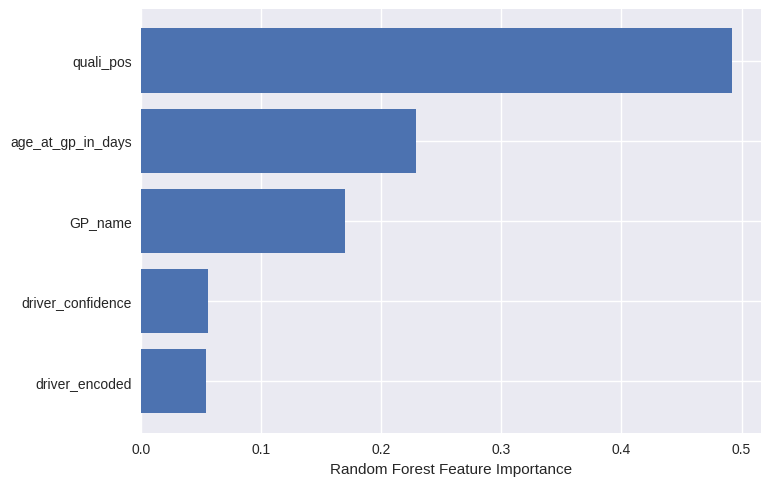

In [ ]:
sorted_idx = rf.feature_importances_.argsort()
plt.barh(X_d_train.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")


### 1.3 Using only active constructors and their relevant features


In [ ]:
x_c = data[['GP_name','quali_pos','constructor','position','constructor_reliablity','active_constructor']]

In [ ]:
x_c = x_c[x_c['active_constructor']==1]

In [ ]:
sc  = StandardScaler()
le = LabelEncoder()
x_c['GP_name'] = le.fit_transform(x_c['GP_name'])
x_c['constructor'] = le.fit_transform(x_c['constructor'])

train, test = train_test_split(x_c, test_size=0.2)

X_c_train = train.drop(['position','active_constructor'],1)
X_c_test = test.drop(['position','active_constructor'],1)
y_c_train = train['position']
y_c_test = test['position']

<ipython-input-38-fa8fde2ac5f5>:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_c_train = train.drop(['position','active_constructor'],1)
<ipython-input-38-fa8fde2ac5f5>:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_c_test = test.drop(['position','active_constructor'],1)


In [ ]:
x_c.head()

,GP_name,quali_pos,constructor,position,constructor_reliablity,active_constructor
18,1,9,2,9,0.610406,1
19,1,12,2,12,0.610406,1
20,1,10,2,12,0.610406,1
21,1,11,2,12,0.610406,1
22,1,3,2,3,0.610406,1


In [ ]:
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_c_train, y_c_train)
y_c_train_pred = rf.predict(X_c_train)
y_c_pred = rf.predict(X_c_test)
print('Training Accuracy: ', accuracy_score(y_c_train, y_c_train_pred))
print('Testing Accuracy: ', accuracy_score(y_c_test, y_c_pred))

Training Accuracy:  0.8680132335016542
Testing Accuracy:  0.6392757660167131


Text(0.5, 0, 'Random Forest Feature Importance')

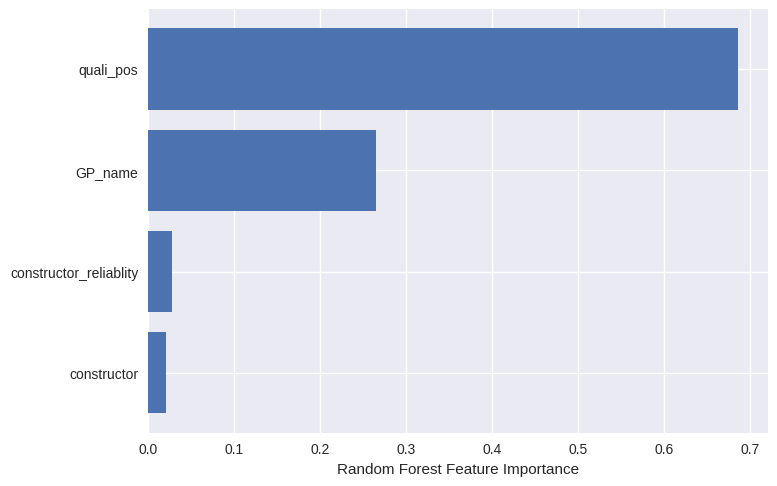

In [ ]:
sorted_idx = rf.feature_importances_.argsort()
plt.barh(X_c_train.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

## Iteration 2: Adding pitstop and laptime data




In [ ]:
data = pd.merge(data,pitstops,how='inner',on=['raceId', 'driverId'])
data = pd.merge(data,laptimes,how='inner',on=['raceId', 'driverId'])

In [ ]:
data.columns

Index(['raceId', 'year', 'date', 'driverId', 'quali_pos', 'statusId',
       'position_x', 'dob', 'driver_nationality', 'constructor',
       'constructor_nationality', 'GP_name', 'country', 'driver',
       'age_at_gp_in_days', 'driver_home', 'constructor_home', 'driver_dnf',
       'constructor_dnf', 'driver_confidence', 'constructor_reliablity',
       'active_driver', 'active_constructor', 'stop', 'lap_x', 'time_x',
       'duration', 'milliseconds_x', 'lap_y', 'position_y', 'time_y',
       'milliseconds_y'],
      dtype='object')

In [ ]:
cols_to_drop = ['duration', 'time_x', 'time_y', 'position_y']
data = data.drop(cols_to_drop, 1)

<ipython-input-44-9e11687d2094>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data = data.drop(cols_to_drop, 1)


In [ ]:
data.rename(columns={'stop': 'pitstop_number', 'lap_x': 'pitstop_lap', 'milliseconds_x': 'pitstop_duration', 'lap_y': 'lap_number', 'milliseconds_y': 'laptime', 'position_x': 'position'},inplace=True)

In [ ]:
data.columns

Index(['raceId', 'year', 'date', 'driverId', 'quali_pos', 'statusId',
       'position', 'dob', 'driver_nationality', 'constructor',
       'constructor_nationality', 'GP_name', 'country', 'driver',
       'age_at_gp_in_days', 'driver_home', 'constructor_home', 'driver_dnf',
       'constructor_dnf', 'driver_confidence', 'constructor_reliablity',
       'active_driver', 'active_constructor', 'pitstop_number', 'pitstop_lap',
       'pitstop_duration', 'lap_number', 'laptime'],
      dtype='object')

### 2.1: Both driver and constructor

In [ ]:
x_cd = data[['GP_name','quali_pos','constructor','driver','position',
             'driver_confidence','constructor_reliablity','active_driver',
             'active_constructor','age_at_gp_in_days','pitstop_number',
             'pitstop_lap','pitstop_duration','lap_number','laptime']]
x_cd = x_cd[(x_cd['active_driver']==1)&(x_cd['active_constructor']==1)]

In [ ]:
sc  = StandardScaler()
le = LabelEncoder()

x = x_cd.copy()
x['GP_name'] = le.fit_transform(x['GP_name'])
x['constructor'] = le.fit_transform(x['constructor'])
x['driver'] = le.fit_transform(x['driver'])
x['GP_name'] = le.fit_transform(x['GP_name'])
train, test = train_test_split(x, test_size=0.2)
X_train = train.drop(['position','active_driver','active_constructor'],1)
X_test = test.drop(['position','active_driver','active_constructor'],1)
y_train = train['position']
y_test = test['position']

<ipython-input-48-3a957d88eafb>:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_train = train.drop(['position','active_driver','active_constructor'],1)
<ipython-input-48-3a957d88eafb>:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_test = test.drop(['position','active_driver','active_constructor'],1)


In [ ]:
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_pred = rf.predict(X_test)
print('Training Accuracy: ', accuracy_score(y_train, y_train_pred))
print('Testing Accuracy: ', accuracy_score(y_test, y_pred))

Training Accuracy:  1.0
Testing Accuracy:  0.9999821765943037


In [ ]:
X_train[(X_train['driver']==1) & (X_train['GP_name']==1)]

,GP_name,quali_pos,constructor,driver,driver_confidence,constructor_reliablity,age_at_gp_in_days,pitstop_number,pitstop_lap,pitstop_duration,lap_number,laptime
448335,1,10,6,1,0.902299,0.647764,9558,1,17,29950,1,89742
448951,1,11,4,1,0.902299,0.827174,9726,1,27,30856,50,79905
448444,1,10,6,1,0.902299,0.647764,9558,2,51,30614,47,78405
448424,1,10,6,1,0.902299,0.647764,9558,2,51,30614,27,80665
448459,1,10,6,1,0.902299,0.647764,9558,2,51,30614,62,78118
...,...,...,...,...,...,...,...,...,...,...,...,...
448376,1,10,6,1,0.902299,0.647764,9558,1,17,29950,42,78708
448903,1,11,4,1,0.902299,0.827174,9726,1,27,30856,2,142547
448911,1,11,4,1,0.902299,0.827174,9726,1,27,30856,10,96070
448975,1,11,4,1,0.902299,0.827174,9726,2,33,1582211,11,90757


In [ ]:
data = data[data['pitstop_lap']==data['lap_number']].drop(columns='pitstop_lap')

In [ ]:
data

,raceId,year,date,driverId,quali_pos,statusId,position,dob,driver_nationality,constructor,...,driver_dnf,constructor_dnf,driver_confidence,constructor_reliablity,active_driver,active_constructor,pitstop_number,pitstop_duration,lap_number,laptime
14,841,2011,2011-03-27,2,18,11,18,1977-05-10,Ger,Alpine F1 Team,...,0,1,0.950000,0.610406,0,1,1,22994,15,114318
86,841,2011,2011-03-27,2,18,11,18,1977-05-10,Ger,Alpine F1 Team,...,0,1,0.950000,0.610406,0,1,2,25098,30,114826
129,969,2017,2017-03-26,807,11,11,12,1987-08-19,Ger,Alpine F1 Team,...,0,1,0.907692,0.610406,1,1,1,23130,16,109892
199,969,2017,2017-03-26,807,11,11,12,1987-08-19,Ger,Alpine F1 Team,...,0,1,0.907692,0.610406,1,1,2,23159,30,110816
260,989,2018,2018-03-25,807,7,1,8,1987-08-19,Ger,Alpine F1 Team,...,0,0,0.907692,0.610406,1,1,1,22628,24,108142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578961,1051,2021,2021-11-21,853,20,12,20,1999-03-02,Rus,Haas F1 Team,...,0,1,0.863636,0.372990,0,1,1,26515,31,114304
578998,1051,2021,2021-11-21,842,2,11,4,1996-02-07,Fre,AlphaTauri,...,0,1,0.915966,0.483063,1,1,1,25630,13,112700
579076,1051,2021,2021-11-21,842,2,11,4,1996-02-07,Fre,AlphaTauri,...,0,1,0.915966,0.483063,1,1,2,26109,35,110401
579106,1051,2021,2021-11-21,852,8,11,8,2000-05-11,Jap,AlphaTauri,...,0,1,0.928571,0.483063,1,1,1,25659,9,114105


In [ ]:
x_cd = data[['GP_name','quali_pos','constructor','driver','position',
             'driver_confidence','constructor_reliablity','active_driver',
             'active_constructor','age_at_gp_in_days','pitstop_number',
              'pitstop_duration','lap_number','laptime']]
x_cd = x_cd[(x_cd['active_driver']==1)&(x_cd['active_constructor']==1)]

In [ ]:
sc  = StandardScaler()
le = LabelEncoder()

x = x_cd.copy()
x['GP_name'] = le.fit_transform(x['GP_name'])
x['constructor'] = le.fit_transform(x['constructor'])
x['driver'] = le.fit_transform(x['driver'])
x['GP_name'] = le.fit_transform(x['GP_name'])
train, test = train_test_split(x, test_size=0.2)
X_train = train.drop(['position','active_driver','active_constructor'],1)
X_test = test.drop(['position','active_driver','active_constructor'],1)
y_train = train['position']
y_test = test['position']

<ipython-input-54-3a957d88eafb>:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_train = train.drop(['position','active_driver','active_constructor'],1)
<ipython-input-54-3a957d88eafb>:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_test = test.drop(['position','active_driver','active_constructor'],1)


In [ ]:
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_pred = rf.predict(X_test)
print('Training Accuracy: ', accuracy_score(y_train, y_train_pred))
print('Testing Accuracy: ', accuracy_score(y_test, y_pred))

Training Accuracy:  1.0
Testing Accuracy:  0.7972972972972973


Text(0.5, 0, 'Random Forest Feature Importance')

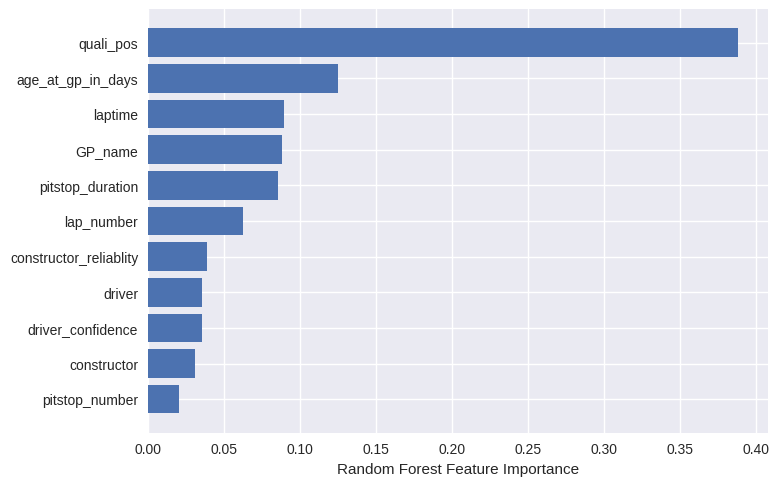

In [ ]:
sorted_idx = rf.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### 2.2 Only Driver

In [ ]:
x_d = data[['GP_name','quali_pos','driver','age_at_gp_in_days','position','driver_confidence','active_driver','lap_number','laptime']]

In [ ]:
x_d = x_d[x_d['active_driver']==1]

In [ ]:
sc  = StandardScaler()
le = LabelEncoder()
x_d['driver_encoded'] = le.fit_transform(x_d['driver'])
# After label encoding
driver_nums = x_d['driver_encoded'].unique()
driver_names = x_d['driver'].unique()

# Create a dictionary that maps driver numbers to names
driver_dict = dict(zip(driver_nums, driver_names))
x_d['GP_name'] = le.fit_transform(x_d['GP_name'])
x_d['GP_name'] = le.fit_transform(x_d['GP_name'])
x_d['age_at_gp_in_days'] = sc.fit_transform(x_d[['age_at_gp_in_days']])

train, test = train_test_split(x_d, test_size=0.2)

X_d_train = train.drop(['position','active_driver','driver'],1)
X_d_test = test.drop(['position','active_driver','driver'],1)
y_d_train = train['position']
y_d_test = test['position']

<ipython-input-59-508b4f0134ae>:16: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_d_train = train.drop(['position','active_driver','driver'],1)
<ipython-input-59-508b4f0134ae>:17: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_d_test = test.drop(['position','active_driver','driver'],1)


In [ ]:
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_d_train, y_d_train)
y_d_train_pred = rf.predict(X_d_train)
y_d_pred = rf.predict(X_d_test)
print('Training Accuracy: ', accuracy_score(y_d_train, y_d_train_pred))
print('Testing Accuracy: ', accuracy_score(y_d_test, y_d_pred))

Training Accuracy:  1.0
Testing Accuracy:  0.8372811534500515


Text(0.5, 0, 'Random Forest Feature Importance')

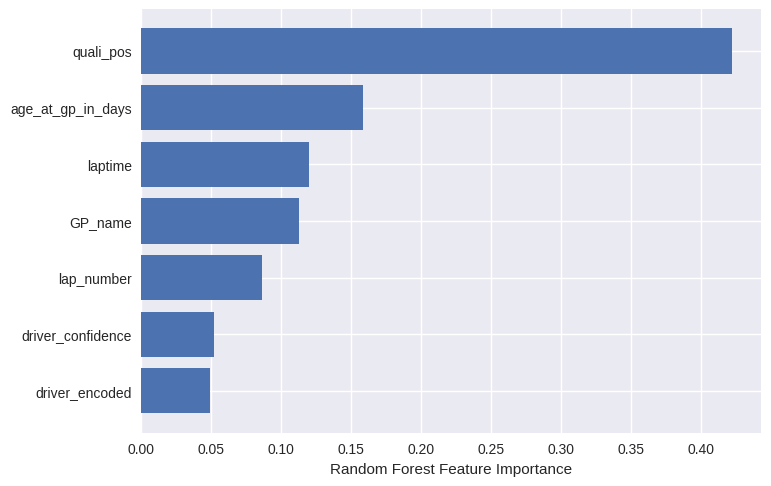

In [ ]:
sorted_idx = rf.feature_importances_.argsort()
plt.barh(X_d_train.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### 2.3 Only Constructor

In [ ]:
x_c = data[['GP_name','quali_pos','constructor','position','constructor_reliablity','active_constructor', 'pitstop_number',
              'pitstop_duration','lap_number']]

In [ ]:
x_c = x_c[x_c['active_constructor']==1]

In [ ]:
sc  = StandardScaler()
le = LabelEncoder()
x_c['GP_name'] = le.fit_transform(x_c['GP_name'])
x_c['constructor'] = le.fit_transform(x_c['constructor'])

train, test = train_test_split(x_c, test_size=0.2)

X_c_train = train.drop(['position','active_constructor'],1)
X_c_test = test.drop(['position','active_constructor'],1)
y_c_train = train['position']
y_c_test = test['position']

<ipython-input-64-fa8fde2ac5f5>:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_c_train = train.drop(['position','active_constructor'],1)
<ipython-input-64-fa8fde2ac5f5>:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_c_test = test.drop(['position','active_constructor'],1)


In [ ]:
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_c_train, y_c_train)
y_c_train_pred = rf.predict(X_c_train)
y_c_pred = rf.predict(X_c_test)
print('Training Accuracy: ', accuracy_score(y_c_train, y_c_train_pred))
print('Testing Accuracy: ', accuracy_score(y_c_test, y_c_pred))

Training Accuracy:  1.0
Testing Accuracy:  0.6906198573779484


Text(0.5, 0, 'Random Forest Feature Importance')

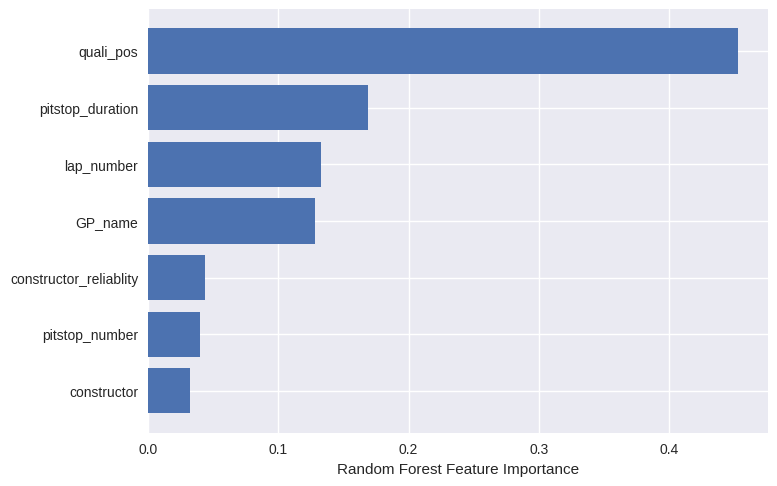

In [ ]:
sorted_idx = rf.feature_importances_.argsort()
plt.barh(X_c_train.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

## Iteration 3: Adding Race Track Images

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import os

In [ ]:
# Read the .geojson file using GeoPandas
folder_path = '/content/drive/MyDrive/F1/f1-circuits/circuits/'

# Get a list of all .geojson files in the folder
geojson_files = [file for file in os.listdir(folder_path) if file.endswith('.geojson')]
list_of_dataframes = []

for file in geojson_files:
    file_path = os.path.join(folder_path, file)
    geo_data = gpd.read_file(file_path)
    list_of_dataframes.append(geo_data)

In [ ]:
list_of_dataframes[0]

,id,Location,Name,opened,firstgp,length,altitude,geometry
0,us-2023,Las Vegas,Las Vegas Street Circuit,2023,2023,6116,610,"LINESTRING (-115.16222 36.10902, -115.16025 36..."


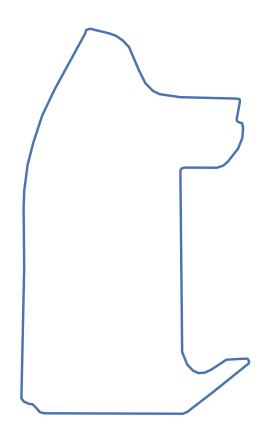

In [ ]:
# plot example of a geojson
fig, ax = plt.subplots()
list_of_dataframes[0].plot(ax=ax)
plt.axis('off')  # Turn off axis for a cleaner image
plt.show()

In [ ]:
# convert each circuit into an image and append it to a list
list_of_images = []

for circuit in list_of_dataframes:
    # Create a plot or canvas to represent the circuit
    fig, ax = plt.subplots(figsize=(8, 8))
    circuit.plot(ax=ax)  # Plot the geographic features onto the canvas
    ax.set_axis_off()  # Turn off the axis
    plt.tight_layout()

    # Convert the plot to an image (numpy array)
    fig.canvas.draw()
    image = np.array(fig.canvas.renderer._renderer)
    list_of_images.append(image)
    plt.close()

In [ ]:
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from PIL import Image

# Resize and preprocess images to fit VGG16 input requirements
resized_images = []
for img in list_of_images:
    # Resize each image to (224, 224) and convert to RGB if it has an alpha channel
    img_pil = Image.fromarray(img)
    img_pil = img_pil.resize((224, 224))
    img_resized = np.array(img_pil.convert('RGB'))
    resized_images.append(img_resized)

# Convert list_of_images to array
resized_images = np.array(resized_images)

# Load the pre-trained VGG16 model without the fully connected layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Preprocess the resized images to fit VGG16 input requirements
preprocessed_images = preprocess_input(resized_images.astype(np.float32))

# Extract features using the pre-trained VGG16 model
features = base_model.predict(preprocessed_images)

# Flatten the extracted features
flattened_features = features.reshape(features.shape[0], -1)


2/2 [==============================] - 25s 2s/step


In [ ]:
flattened_features.shape

(35, 25088)

In [ ]:
combined_gdf = gpd.GeoDataFrame(pd.concat(list_of_dataframes, ignore_index=True), crs=list_of_dataframes[0].crs).drop(columns="geometry")

In [ ]:
combined_gdf['extracted_features'] = flattened_features.tolist()

In [ ]:
combined_gdf.head()

,id,Location,Name,opened,firstgp,length,altitude,extracted_features
0,us-2023,Las Vegas,Las Vegas Street Circuit,2023,2023,6116,610,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,us-2012,Austin,Circuit of the Americas,2012,2012,5514,130,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,us-2022,Miami,Miami International Autodrome,2022,2022,5412,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,az-2016,Baku,Baku City Circuit,2016,2016,6003,-25,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,mx-1962,Mexico City,Autódromo Hermanos Rodríguez,1962,1963,4304,2232,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
data_track = data

In [ ]:
data_track['GP_name']

14        Albert Park Grand Prix Circuit
86        Albert Park Grand Prix Circuit
129       Albert Park Grand Prix Circuit
199       Albert Park Grand Prix Circuit
260       Albert Park Grand Prix Circuit
                       ...              
578961      Losail International Circuit
578998      Losail International Circuit
579076      Losail International Circuit
579106      Losail International Circuit
579187      Losail International Circuit
Name: GP_name, Length: 10037, dtype: object

In [ ]:
track_name_mapping = {
    'Albert Park Grand Prix Circuit': 'Albert Park Circuit',
    'Autodromo Enzo e Dino Ferrari': 'Autodromo Internazionale del Mugello',
    'Autodromo Internazionale del Mugello': 'Autodromo Internazionale del Mugello',
    'Autodromo Nazionale di Monza': 'Autodromo Nazionale Monza',
    'Autódromo Hermanos Rodríguez': 'Autódromo Hermanos Rodríguez',
    'Autódromo Internacional do Algarve': 'Autódromo Internacional do Algarve',
    'Autódromo José Carlos Pace': 'Autódromo José Carlos Pace - Interlagos',
    'Bahrain International Circuit': 'Bahrain International Circuit',
    'Baku City Circuit': 'Baku City Circuit',
    'Buddh International Circuit': 'Not Available',  # Couldn't find a match in the provided circuits
    'Circuit Gilles Villeneuve': 'Circuit Gilles-Villeneuve',
    'Circuit Park Zandvoort': 'Circuit Zandvoort',
    'Circuit Paul Ricard': 'Circuit Paul Ricard',
    'Circuit de Barcelona-Catalunya': 'Circuit de Barcelona-Catalunya',
    'Circuit de Monaco': 'Circuit de Monaco',
    'Circuit de Spa-Francorchamps': 'Circuit de Spa-Francorchamps',
    'Circuit of the Americas': 'Circuit of the Americas',
    'Hockenheimring': 'Hockenheimring',
    'Hungaroring': 'Hungaroring',
    'Istanbul Park': 'Intercity Istanbul Park',
    'Jeddah Corniche Circuit': 'Jeddah Corniche Circuit',
    'Korean International Circuit': 'Not Available',  # Couldn't find a match in the provided circuits
    'Losail International Circuit': 'Losail International Circuit',
    'Marina Bay Street Circuit': 'Marina Bay Street Circuit',
    'Miami International Autodrome': 'Miami International Autodrome',
    'Nürburgring': 'Nürburgring',
    'Red Bull Ring': 'Red Bull Ring',
    'Sepang International Circuit': 'Sepang International Circuit',
    'Shanghai International Circuit': 'Shanghai International Circuit',
    'Silverstone Circuit': 'Silverstone Circuit',
    'Sochi Autodrom': 'Sochi Autodrom',
    'Suzuka Circuit': 'Suzuka International Racing Course',
    'Valencia Street Circuit': 'Not Available',  # Couldn't find a match in the provided circuits
    'Yas Marina Circuit': 'Yas Marina Circuit'
}


In [ ]:
import pandas as pd

corresponding_rows_df = pd.DataFrame()  # New DataFrame to store corresponding rows
rows_to_drop = []  # List to collect rows to drop

for index, row in data_track.iterrows():
    track_name = row['GP_name']
    mapped_name = track_name_mapping.get(track_name)

    if mapped_name not in combined_gdf['Name'].tolist():
        rows_to_drop.append(index)
        print(f"Track name '{track_name}' not found in combined_gdf")

# Drop rows collected in rows_to_drop list from x_t
data_track.drop(rows_to_drop, inplace=True)

# Now proceed to collect corresponding rows from combined_gdf as before
for index, row in data_track.iterrows():
    mapped_name = track_name_mapping.get(row['GP_name'])

    if mapped_name in combined_gdf['Name'].tolist():
        row_numbers = combined_gdf.index[combined_gdf['Name'] == mapped_name].tolist()
        corresponding_rows = combined_gdf.iloc[row_numbers]
        corresponding_rows_df = corresponding_rows_df.append(corresponding_rows, ignore_index=True)

# The corresponding_rows_df DataFrame now contains all corresponding rows from combined_gdf

Track name 'Valencia Street Circuit' not found in combined_gdf
Track name 'Valencia Street Circuit' not found in combined_gdf
Track name 'Valencia Street Circuit' not found in combined_gdf
Track name 'Valencia Street Circuit' not found in combined_gdf
Track name 'Valencia Street Circuit' not found in combined_gdf
Track name 'Valencia Street Circuit' not found in combined_gdf
Track name 'Valencia Street Circuit' not found in combined_gdf
Track name 'Valencia Street Circuit' not found in combined_gdf
Track name 'Valencia Street Circuit' not found in combined_gdf
Track name 'Valencia Street Circuit' not found in combined_gdf
Track name 'Valencia Street Circuit' not found in combined_gdf
Track name 'Valencia Street Circuit' not found in combined_gdf
Track name 'Valencia Street Circuit' not found in combined_gdf
Track name 'Valencia Street Circuit' not found in combined_gdf
Track name 'Valencia Street Circuit' not found in combined_gdf
Track name 'Valencia Street Circuit' not found in combi

<ipython-input-80-57255b601c5b>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  corresponding_rows_df = corresponding_rows_df.append(corresponding_rows, ignore_index=True)


In [ ]:
data_track['GP_name']

14        Albert Park Grand Prix Circuit
86        Albert Park Grand Prix Circuit
129       Albert Park Grand Prix Circuit
199       Albert Park Grand Prix Circuit
260       Albert Park Grand Prix Circuit
                       ...              
578961      Losail International Circuit
578998      Losail International Circuit
579076      Losail International Circuit
579106      Losail International Circuit
579187      Losail International Circuit
Name: GP_name, Length: 9665, dtype: object

In [ ]:
data_track = data_track.reset_index(drop=True)

In [ ]:
corresponding_rows_df

,id,Location,Name,opened,firstgp,length,altitude,extracted_features
0,au-1953,Melbourne,Albert Park Circuit,1953,1996,5278,10,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,au-1953,Melbourne,Albert Park Circuit,1953,1996,5278,10,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,au-1953,Melbourne,Albert Park Circuit,1953,1996,5278,10,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,au-1953,Melbourne,Albert Park Circuit,1953,1996,5278,10,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,au-1953,Melbourne,Albert Park Circuit,1953,1996,5278,10,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
9660,qa-2004,Lusail,Losail International Circuit,2004,2021,5380,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9661,qa-2004,Lusail,Losail International Circuit,2004,2021,5380,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9662,qa-2004,Lusail,Losail International Circuit,2004,2021,5380,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9663,qa-2004,Lusail,Losail International Circuit,2004,2021,5380,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
data_track = pd.concat([data_track, corresponding_rows_df], axis=1)

In [ ]:
data_track

,raceId,year,date,driverId,quali_pos,statusId,position,dob,driver_nationality,constructor,...,lap_number,laptime,id,Location,Name,opened,firstgp,length,altitude,extracted_features
0,841,2011,2011-03-27,2,18,11,18,1977-05-10,Ger,Alpine F1 Team,...,15,114318,au-1953,Melbourne,Albert Park Circuit,1953,1996,5278,10,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,841,2011,2011-03-27,2,18,11,18,1977-05-10,Ger,Alpine F1 Team,...,30,114826,au-1953,Melbourne,Albert Park Circuit,1953,1996,5278,10,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,969,2017,2017-03-26,807,11,11,12,1987-08-19,Ger,Alpine F1 Team,...,16,109892,au-1953,Melbourne,Albert Park Circuit,1953,1996,5278,10,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,969,2017,2017-03-26,807,11,11,12,1987-08-19,Ger,Alpine F1 Team,...,30,110816,au-1953,Melbourne,Albert Park Circuit,1953,1996,5278,10,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,989,2018,2018-03-25,807,7,1,8,1987-08-19,Ger,Alpine F1 Team,...,24,108142,au-1953,Melbourne,Albert Park Circuit,1953,1996,5278,10,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9660,1051,2021,2021-11-21,853,20,12,20,1999-03-02,Rus,Haas F1 Team,...,31,114304,qa-2004,Lusail,Losail International Circuit,2004,2021,5380,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9661,1051,2021,2021-11-21,842,2,11,4,1996-02-07,Fre,AlphaTauri,...,13,112700,qa-2004,Lusail,Losail International Circuit,2004,2021,5380,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9662,1051,2021,2021-11-21,842,2,11,4,1996-02-07,Fre,AlphaTauri,...,35,110401,qa-2004,Lusail,Losail International Circuit,2004,2021,5380,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9663,1051,2021,2021-11-21,852,8,11,8,2000-05-11,Jap,AlphaTauri,...,9,114105,qa-2004,Lusail,Losail International Circuit,2004,2021,5380,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
# Expand the 'extracted_features' column into separate columns
df_features = pd.DataFrame(data_track['extracted_features'].to_list(), columns=[f'feature_{i}' for i in range(len(data_track['extracted_features'].iloc[0]))])
df_features

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_25078,feature_25079,feature_25080,feature_25081,feature_25082,feature_25083,feature_25084,feature_25085,feature_25086,feature_25087
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9660,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9661,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9662,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9663,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Concatenate the expanded columns with the original DataFrame
data_track = pd.concat([data_track.drop(columns=['extracted_features']), df_features], axis=1)

In [ ]:
data_track.columns

Index(['raceId', 'year', 'date', 'driverId', 'quali_pos', 'statusId',
       'position', 'dob', 'driver_nationality', 'constructor',
       ...
       'feature_25078', 'feature_25079', 'feature_25080', 'feature_25081',
       'feature_25082', 'feature_25083', 'feature_25084', 'feature_25085',
       'feature_25086', 'feature_25087'],
      dtype='object', length=25122)

In [ ]:
del df_features

Exploratory data analysis

In [ ]:
data_track.columns[:50]

Index(['raceId', 'year', 'date', 'driverId', 'quali_pos', 'statusId',
       'position', 'dob', 'driver_nationality', 'constructor',
       'constructor_nationality', 'GP_name', 'country', 'driver',
       'age_at_gp_in_days', 'driver_home', 'constructor_home', 'driver_dnf',
       'constructor_dnf', 'driver_confidence', 'constructor_reliablity',
       'active_driver', 'active_constructor', 'pitstop_number',
       'pitstop_duration', 'lap_number', 'laptime', 'id', 'Location', 'Name',
       'opened', 'firstgp', 'length', 'altitude', 'feature_0', 'feature_1',
       'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6',
       'feature_7', 'feature_8', 'feature_9', 'feature_10', 'feature_11',
       'feature_12', 'feature_13', 'feature_14', 'feature_15'],
      dtype='object')

In [ ]:
cols_to_omit = ['raceId','year','date', 'driverId', 'statusId',
       'dob','driver_nationality','constructor_nationality',
       'country','driver_home', 'constructor_home','driver_dnf',
       'constructor_dnf','id','Location', 'Name','opened','firstgp','pitstop_number',
        'pitstop_duration', 'active_constructor', 'constructor_reliablity', 'constructor']
x_t_final = data_track[[i for i in list(data_track.columns) if i not in cols_to_omit]]
x_t_final = x_cd[(x_cd['active_driver']==1)]

In [ ]:
x_t_final.columns[:30]

Index(['GP_name', 'quali_pos', 'constructor', 'driver', 'position',
       'driver_confidence', 'constructor_reliablity', 'active_driver',
       'active_constructor', 'age_at_gp_in_days', 'pitstop_number',
       'pitstop_duration', 'lap_number', 'laptime'],
      dtype='object')

In [ ]:
sc  = StandardScaler()
le = LabelEncoder()
x_t_final['driver_encoded'] = le.fit_transform(x_t_final['driver'])
# After label encoding
driver_nums = x_t_final['driver_encoded'].unique()
driver_names = x_t_final['driver'].unique()

# Create a dictionary that maps driver numbers to names
driver_dict = dict(zip(driver_nums, driver_names))
x_t_final['GP_name'] = le.fit_transform(x_t_final['GP_name'])
x_t_final['GP_name'] = le.fit_transform(x_t_final['GP_name'])
x_t_final['age_at_gp_in_days'] = sc.fit_transform(x_t_final[['age_at_gp_in_days']])

In [ ]:
train, test = train_test_split(x_t_final, test_size=0.2)
X_t_train = train.drop(['position','active_driver','driver'],1)
X_t_test = test.drop(['position','active_driver','driver'],1)
y_t_train = train['position']
y_t_test = test['position']

<ipython-input-322-3381097fb819>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_t_train = train.drop(['position','active_driver','driver','id','Name','Location','opened','firstgp',"track_names"],1)
<ipython-input-322-3381097fb819>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_t_test = test.drop(['position','active_driver','driver','id','Name','Location','opened','firstgp',"track_names"],1)


In [ ]:
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_t_train, y_t_train)
y_t_train_pred = rf.predict(X_t_train)
y_t_pred = rf.predict(X_t_test)
print('Training Accuracy: ', accuracy_score(y_t_train, y_t_train_pred))
print('Testing Accuracy: ', accuracy_score(y_t_test, y_t_pred))

Training Accuracy:  1.0
Testing Accuracy:  0.5842931937172775


In [ ]:
sorted_idx = rf.feature_importances_.argsort()

In [ ]:
top_10_features = X_t_train.columns[sorted_idx][-10:]
top_10_importance = rf.feature_importances_[sorted_idx][-10:]

Text(0.5, 0, 'Random Forest Feature Importance')

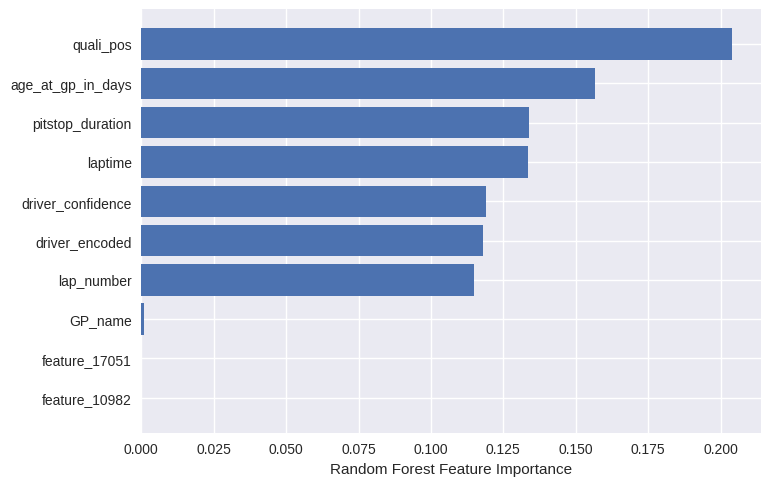

In [ ]:
plt.barh(top_10_features, top_10_importance)
plt.xlabel("Random Forest Feature Importance")



## SELECT THE HIGHEST IMPORTANCE FEATURES TO RETRAIN AND OBSERVE PERFORMANCE

In [ ]:
# SELECT THE HIGHEST IMPORTANCE FEATURES ONLY AND RETRAIN THE MODEL
X_t_train_final = X_t_train[['quali_pos', 'age_at_gp_in_days', 'pitstop_duration','laptime', 'driver_confidence', 'driver_encoded', 'lap_number','GP_name', 'feature_17051', 'feature_10982']]
X_t_test_final = X_t_test[['quali_pos', 'age_at_gp_in_days', 'pitstop_duration','laptime', 'driver_confidence', 'driver_encoded', 'lap_number','GP_name', 'feature_17051', 'feature_10982']]
y_t_train_final = train['position']
y_t_test_final = test['position']

In [ ]:
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_t_train_final, y_t_train_final)
y_t_train_pred_final = rf.predict(X_t_train_final)
y_t_pred_final = rf.predict(X_t_test_final)
print('Training Accuracy: ', accuracy_score(y_t_train_final, y_t_train_pred_final))
print('Testing Accuracy: ', accuracy_score(y_t_test_final, y_t_pred_final))

Training Accuracy:  1.0
Testing Accuracy:  0.8513089005235602


## Conclusions

The incorporation of pitstop and laptime data significantly improved the accuracy of our predictive models, emphasizing the relevance of these features in forecasting Formula 1 race outcomes. The refined model, focused on active drivers and constructors, demonstrated notable enhancements in testing accuracy, with the driver-specific dataset proving more influential than its constructor-oriented counterpart. This underscores the preeminence of driver-related attributes in shaping race results. Moreover, our exploration into race track data, utilizing a Convolutional Neural Network (CNN) for feature extraction, yielded our highest-performing model with a testing accuracy of 0.85. While track characteristics were identified as contributors to race predictions, they remained subordinate to the dominance of driver and constructor attributes, revealing a nuanced hierarchy in the factors influencing Formula 1 outcomes.

Despite these successes, our analysis acknowledges certain limitations. The absence of key features such as tyre data, track banking, and weather conditions poses opportunities for further refinement to enhance predictive accuracy. These elements, integral to the nature of Formula 1 races, could be crucial additions in future iterations. Additionally, careful consideration is needed in addressing the sparsity and noise introduced by certain image-based features and also the scarce data of newer drivers. In conclusion, our multimodal machine learning approach provides valuable insights into the dynamics of Formula 1 races, helping us analyze key features and their importance in playing a role in the outcome of a race and brings us a step closer in answering the age-old question is the driver more important or the car.